<a href="https://colab.research.google.com/github/1ssethDesu/ML_model/blob/main/Denteeth_ML_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Load the dataset**

In [1]:
!pip install ultralytics
!pip install roboflow
from google.colab import userdata
api_key = userdata.get('api_key')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:

from roboflow import Roboflow
rf = Roboflow(api_key=api_key)
project = rf.workspace("denteeth-jw0ac").project("denteeth-uyyfj")
version = project.version(8)
dataset = version.download("coco")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to denteeth-8 in coco:: 100%|██████████| 1944/1944 [00:00<00:00, 3819.35it/s]


In [3]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import CocoDetection
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
from PIL import Image

# **Transform Coco to Pytorch Tensor**

In [5]:
# Define transformations
class CocoTransform:
    def __call__(self, image, target):
        image = F.to_tensor(image)  # Convert PIL image to tensor
        return image, target

# **Prepare data loader**

In [6]:
# Dataset class
def get_coco_dataset(img_dir, ann_file):
    return CocoDetection(
        root=img_dir,
        annFile=ann_file,
        transforms=CocoTransform()
    )

# Load datasets
train_dataset = get_coco_dataset(
    img_dir="/content/denteeth-8/train",
    ann_file="/content/denteeth-8/train/_annotations.coco.json"
)


val_dataset = get_coco_dataset(
    img_dir="/content/denteeth-8/valid",
    ann_file="/content/denteeth-8/valid/_annotations.coco.json"
)



loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [7]:
# DataLoader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# **Building Model**

In [8]:
def get_model(num_classes):
    # Load pre-trained Faster R-CNN
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [9]:
# Initialize the model
num_classes = 4 # Background + tooth-decay, tooth-loss, gum-disease
model = get_model(num_classes)

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 171MB/s]


In [10]:
# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Define optimizer and learning rate scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.5/962.5 kB 25.8 MB/s eta 0:00:00


In [ ]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    # Initialize metric
    metric = MeanAveragePrecision(box_format='xyxy', class_metrics=True)

    total_loss = 0

    for images, targets in data_loader:
        # Move images to the device
        images = [img.to(device) for img in images]

        # Validate and process targets
        processed_targets = []
        valid_images = []
        for i, target in enumerate(targets):
            boxes = []
            labels = []
            for obj in target:
                bbox = obj["bbox"]
                x, y, w, h = bbox
                if w > 0 and h > 0:
                    boxes.append([x, y, x + w, y + h])
                    labels.append(obj["category_id"])

            if boxes:
                processed_target = {
                    "boxes": torch.tensor(boxes, dtype=torch.float32).to(device),
                    "labels": torch.tensor(labels, dtype=torch.int64).to(device),
                }
                processed_targets.append(processed_target)
                valid_images.append(images[i])

        if not processed_targets:
            continue

        images = valid_images

        # Forward pass
        loss_dict = model(images, processed_targets)
        losses = sum(loss for loss in loss_dict.values())
        total_loss += losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        # Switch to eval to compute predictions
        model.eval()
        with torch.no_grad():
            predictions = model(images)
            formatted_predictions = [{
                "boxes": pred["boxes"].detach().cpu(),
                "scores": pred["scores"].detach().cpu(),
                "labels": pred["labels"].detach().cpu(),
            } for pred in predictions]

            formatted_targets = [{
                "boxes": tgt["boxes"].detach().cpu(),
                "labels": tgt["labels"].detach().cpu(),
            } for tgt in processed_targets]

            metric.update(formatted_predictions, formatted_targets)

        model.train()

    # 🔧 FIX: compute metrics AFTER the loop
    metrics = metric.compute()
    avg_loss = total_loss / len(data_loader)

    print(f"Epoch [{epoch}] Loss: {avg_loss:.4f} | "
          f"mAP: {metrics['map']:.4f} | "
          f"mAP@0.5: {metrics['map_50']:.4f} | "
          f"mAP@0.75: {metrics['map_75']:.4f}")


In [ ]:
import os

model_dir = "/content/drive/MyDrive/Denteeth /models/Fast_rcnn_resnet50"
os.makedirs(model_dir, exist_ok=True)

In [ ]:
# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)
    lr_scheduler.step()

    # Save the model's state dictionary after every epoch
    model_path = os.path.join(model_dir, f"fasterrcnn_resnet50_epoch_{epoch + 1}.pth")
    torch.save(model.state_dict(), model_path)
    print(f"Model saved: {model_path}")

Epoch [0] Loss: 0.2974 | mAP: 0.5104 | mAP@0.5: 0.9121 | mAP@0.75: 0.5158
Model saved: /content/drive/MyDrive/Denteeth /models/Fast_rcnn_resnet50/fasterrcnn_resnet50_epoch_1.pth
Epoch [1] Loss: 0.2732 | mAP: 0.5455 | mAP@0.5: 0.9329 | mAP@0.75: 0.5776
Model saved: /content/drive/MyDrive/Denteeth /models/Fast_rcnn_resnet50/fasterrcnn_resnet50_epoch_2.pth
Epoch [2] Loss: 0.2693 | mAP: 0.5499 | mAP@0.5: 0.9356 | mAP@0.75: 0.5867
Model saved: /content/drive/MyDrive/Denteeth /models/Fast_rcnn_resnet50/fasterrcnn_resnet50_epoch_3.pth
Epoch [3] Loss: 0.2663 | mAP: 0.5545 | mAP@0.5: 0.9384 | mAP@0.75: 0.5900
Model saved: /content/drive/MyDrive/Denteeth /models/Fast_rcnn_resnet50/fasterrcnn_resnet50_epoch_4.pth
Epoch [4] Loss: 0.2637 | mAP: 0.5583 | mAP@0.5: 0.9401 | mAP@0.75: 0.5964
Model saved: /content/drive/MyDrive/Denteeth /models/Fast_rcnn_resnet50/fasterrcnn_resnet50_epoch_5.pth


# **Model Testing (With .pth format)**

In [12]:
# Load the trained model
model = get_model(num_classes)
model.load_state_dict(torch.load("/content/drive/MyDrive/Denteeth /models/Fast_rcnn_resnet50/fasterrcnn_resnet50_epoch_5.pth"))
model.to(device)
model.eval()

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
def prepare_image(image_path):
    image = Image.open(image_path).convert("RGB")  # Open image
    image_tensor = F.to_tensor(image).unsqueeze(0)  # Convert image to tensor and add batch dimension
    return image_tensor.to(device)


In [23]:
import matplotlib.pyplot as plt

# Color map by class name
class_colors = {
    "gum-disease": "g",    # green
    "tooth-decay": "r",    # red
    "tooth-loss": "b",     # blue
    "Unknown": "y"         # fallback: yellow
}

def get_class_name(class_id):
    COCO_CLASSES = {
        0: "Background",
        1: "gum-disease",
        2: "tooth-decay",
        3: "tooth-loss"
    }
    return COCO_CLASSES.get(class_id, "Unknown")

def draw_boxes(image, prediction, fig_size=(10, 10)):
    boxes = prediction[0]['boxes'].cpu().numpy()
    labels = prediction[0]['labels'].cpu().numpy()
    scores = prediction[0]['scores'].cpu().numpy()

    threshold = 0.5
    plt.figure(figsize=fig_size)
    plt.imshow(image)

    for box, label, score in zip(boxes, labels, scores):
        if score > threshold:
            x_min, y_min, x_max, y_max = box
            class_name = get_class_name(label)
            color = class_colors.get(class_name, "y")  # use fallback if class is unknown

            # Draw box
            plt.gca().add_patch(
                plt.Rectangle(
                    (x_min, y_min),
                    x_max - x_min,
                    y_max - y_min,
                    linewidth=2,
                    edgecolor=color,
                    facecolor='none'
                )
            )

            # Draw label
            plt.text(
                x_min,
                y_min - 5,
                f"{class_name} ({score:.2f})",
                color=color,
                fontsize=10,
                weight="bold"
            )

    plt.axis('off')
    plt.show()


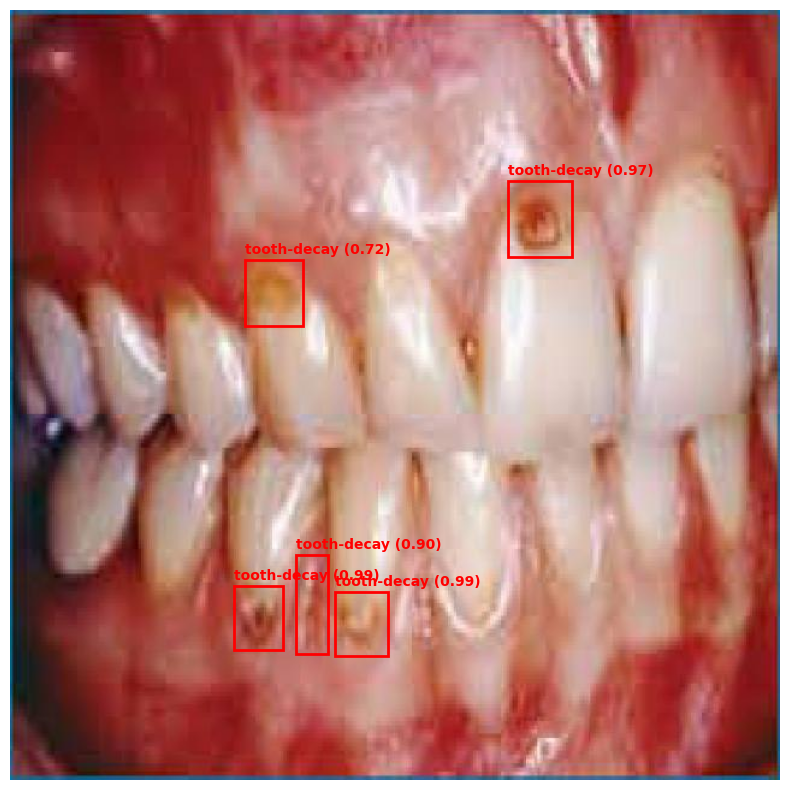

In [ ]:
from PIL import Image

image_path = "/content/denteeth-8/test/teeth-caries_358_jpg.rf.b280d228010f6b5621804488067d91f8.jpg"
image_tensor = prepare_image(image_path)

with torch.no_grad():
    prediction = model(image_tensor)

draw_boxes(Image.open(image_path), prediction, fig_size=(12, 10))

# **Model Testing (With .onnx format)**

In [13]:
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.2 MB/s eta 0:00:00


In [15]:
import onnxruntime

# Assuming device is already defined (either 'cuda' or 'cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the ONNX model
onnx_model_path = "/content/drive/MyDrive/Denteeth /models/fasterrcnn_resnet50.onnx"

try:
    # Create an ONNX Runtime inference session
    # Use the appropriate execution provider ('CUDAExecutionProvider' if using GPU)
    if device.type == 'cuda':
        session = onnxruntime.InferenceSession(onnx_model_path, providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
    else:
        session = onnxruntime.InferenceSession(onnx_model_path, providers=['CPUExecutionProvider'])

    print("ONNX model loaded successfully!")

    # Get input and output names
    input_name = session.get_inputs()[0].name
    output_names = [output.name for output in session.get_outputs()]

    print(f"Input name: {input_name}")
    print(f"Output names: {output_names}")

except Exception as e:
    print(f"Error loading ONNX model: {e}")
    # Handle the error appropriately, perhaps the file doesn't exist or is corrupted.
    session = None # Ensure session is None if loading fails



Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'


ONNX model loaded successfully!
Input name: input
Output names: ['boxes', 'labels', 'scores']


In [16]:
# Define the prepare_image function to work with numpy array for ONNX
def prepare_image_onnx(image_path):
    image = Image.open(image_path).convert("RGB")  # Open image
    # ONNX Runtime typically expects numpy arrays with shape (batch_size, channels, height, width)
    image_tensor = F.to_tensor(image)  # Convert PIL image to tensor (channels, height, width)
    image_numpy = image_tensor.unsqueeze(0).cpu().numpy() # Add batch dimension and convert to numpy
    return image_numpy, image # Also return the PIL image for drawing


In [17]:
def run_onnx_inference(session, image_numpy, input_name, output_names):
    if session is None:
        print("ONNX session is not initialized.")
        return None

    # Run inference
    onnx_outputs = session.run(output_names, {input_name: image_numpy})

    # ONNX output format can vary based on the model export.
    # For object detection models like Faster R-CNN exported to ONNX, the outputs
    # might be in different arrays, typically including:
    # boxes: (N, 4) numpy array of bounding boxes [x1, y1, x2, y2]
    # labels: (N,) numpy array of class labels
    # scores: (N,) numpy array of confidence scores
    # where N is the number of detected objects.

    # You need to inspect the 'onnx_outputs' to understand its structure
    # and map it back to the format expected by your draw_boxes function.
    # This is a placeholder; you'll need to adjust based on your ONNX model's actual output.
    print("ONNX output structure (inspect this to process results):")
    for i, output in enumerate(onnx_outputs):
        print(f"Output {output_names[i]} shape: {output.shape}")

    # Example (assuming specific output names - replace with actual names)
    # boxes = onnx_outputs[output_names.index('boxes')]
    # labels = onnx_outputs[output_names.index('labels')]
    # scores = onnx_outputs[output_names.index('scores')]

    # For now, we'll return the raw outputs and you can process them
    return onnx_outputs


In [25]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np # Import numpy as draw_boxes uses it

# Color map by class name
class_colors = {
    "gum-disease": "g",    # green
    "tooth-decay": "r",    # red
    "tooth-loss": "b",     # blue
    "Unknown": "y"         # fallback: yellow
}

def get_class_name(class_id):
    COCO_CLASSES = {
        0: "Background",
        1: "gum-disease",
        2: "tooth-decay",
        3: "tooth-loss"
    }
    # Ensure class_id is an integer
    return COCO_CLASSES.get(int(class_id), "Unknown")

def draw_boxes(image, prediction, fig_size=(10, 10)):
    # Expecting prediction to be a list containing a dictionary for ONNX output
    # Adapt this part based on the actual structure of your ONNX output
    if not prediction or 'boxes' not in prediction[0] or 'labels' not in prediction[0] or 'scores' not in prediction[0]:
         print("Invalid prediction format for drawing.")
         return

    # Convert tensors to numpy arrays if they aren't already
    boxes = prediction[0]['boxes']
    labels = prediction[0]['labels']
    scores = prediction[0]['scores']

    # Ensure numpy arrays
    if isinstance(boxes, torch.Tensor):
        boxes = boxes.cpu().numpy()
    if isinstance(labels, torch.Tensor):
        labels = labels.cpu().numpy()
    if isinstance(scores, torch.Tensor):
        scores = scores.cpu().numpy()


    threshold = 0.5
    plt.figure(figsize=fig_size)
    plt.imshow(image)

    for box, label, score in zip(boxes, labels, scores):
        if score > threshold:
            x_min, y_min, x_max, y_max = box
            class_name = get_class_name(label)
            color = class_colors.get(class_name, "y")  # use fallback if class is unknown

            # Draw box
            plt.gca().add_patch(
                plt.Rectangle(
                    (x_min, y_min),
                    x_max - x_min,
                    y_max - y_min,
                    linewidth=2,
                    edgecolor=color,
                    facecolor='none'
                )
            )

            # Draw label
            plt.text(
                x_min,
                y_min - 5,
                f"{class_name} ({score:.2f})",
                color=color,
                fontsize=10,
                weight="bold"
            )

    plt.axis('off')
    plt.show()

ONNX output structure (inspect this to process results):
Output boxes shape: (13, 4)
Output labels shape: (13,)
Output scores shape: (13,)


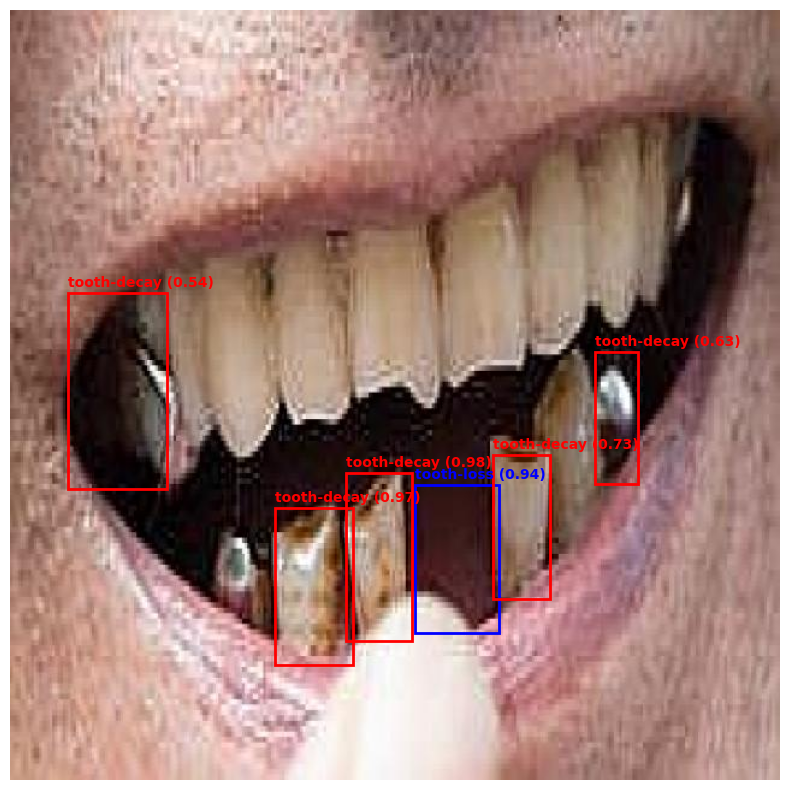

In [28]:

# Example usage:
image_path = "/content/denteeth-8/test/h-1113-_JPG.rf.50776242d6eee39aff0c822ebb4b0088.jpg"
image_numpy, pil_image = prepare_image_onnx(image_path)

if session is not None:
    onnx_prediction = run_onnx_inference(session, image_numpy, input_name, output_names)

# Example of how you might process (adjust based on your ONNX output):
# Ensure this block is NOT indented relative to the 'if session is not None:' block
if onnx_prediction:
    # Assuming the ONNX model outputs boxes, labels, and scores in that order
    onnx_boxes = onnx_prediction[0]
    onnx_labels = onnx_prediction[1]
    onnx_scores = onnx_prediction[2]

    # Convert numpy arrays to tensor format expected by draw_boxes (if needed)
    prediction_for_drawing = [{
        'boxes': torch.from_numpy(onnx_boxes),
        'labels': torch.from_numpy(onnx_labels),
        'scores': torch.from_numpy(onnx_scores)
    }]
    draw_boxes(pil_image, prediction_for_drawing, fig_size=(12, 10))
else:
    print("ONNX inference failed.")

# **Model Evaluations Metrics**